### Import required packages

In [121]:
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import metrics
import re

### Reading data and general overview of it

In [122]:
df = pd.read_csv("/content/Real estate.csv")

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   No                                      414 non-null    int64  
 1   X1 transaction date                     414 non-null    float64
 2   X2 house age                            414 non-null    float64
 3   X3 distance to the nearest MRT station  414 non-null    float64
 4   X4 number of convenience stores         414 non-null    int64  
 5   X5 latitude                             414 non-null    float64
 6   X6 longitude                            414 non-null    float64
 7   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 26.0 KB


,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [123]:
def get_feature_label(feature: str):
  # X6 longitude -> longitude
  return re.sub(r'X\d+\s+', '', feature).capitalize()

In [124]:
def plot_feature(x: pd.Series, y: pd.Series, col: str,index: int,correlation: float | None = None):
  feature_label = get_feature_label(col)

  plt.figure(figsize=(10,6))
  plt.scatter(x, y, color="blue")
  if correlation is not None:
    plt.title(f"Correlation Between {feature_label} And House Price Is {correlation}")
  plt.xlabel(feature_label)
  plt.ylabel("House Price")
  plt.show()

### Feature visualization

<ipython-input-125-27d855b1bb48>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_feature(X[col],Y,col,index,correlations[index])


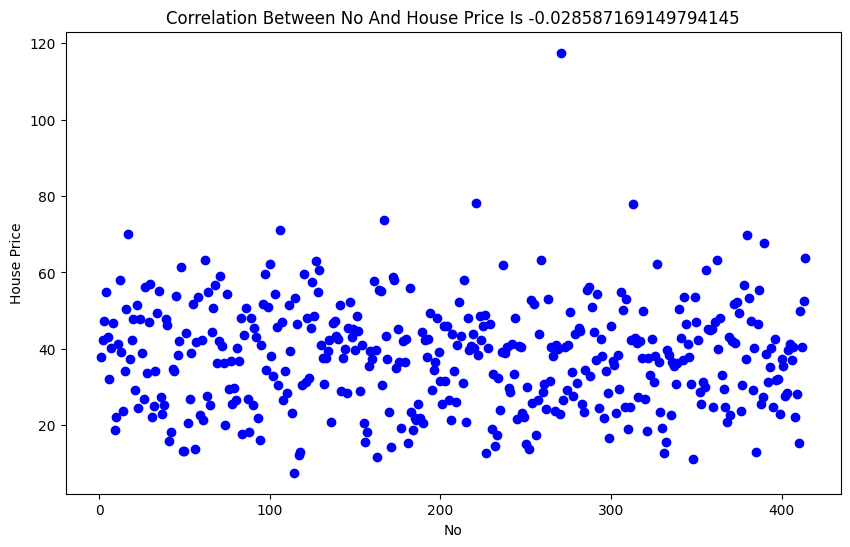

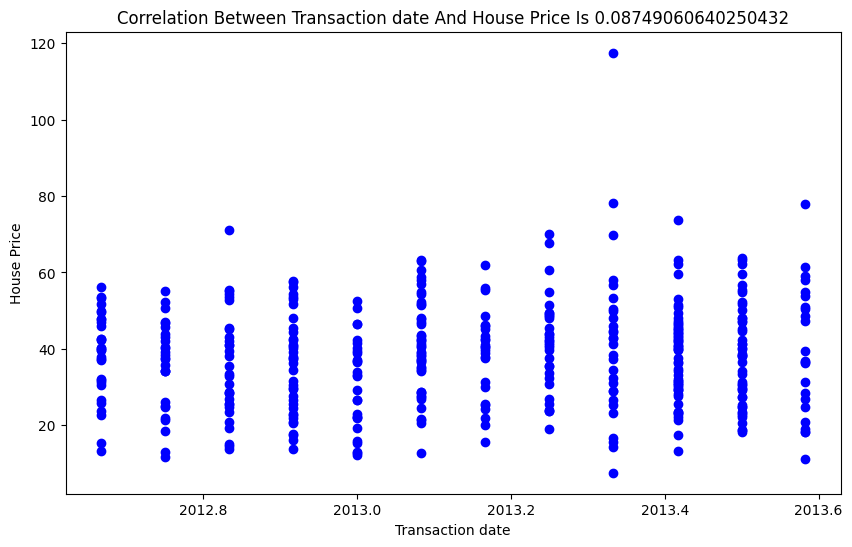

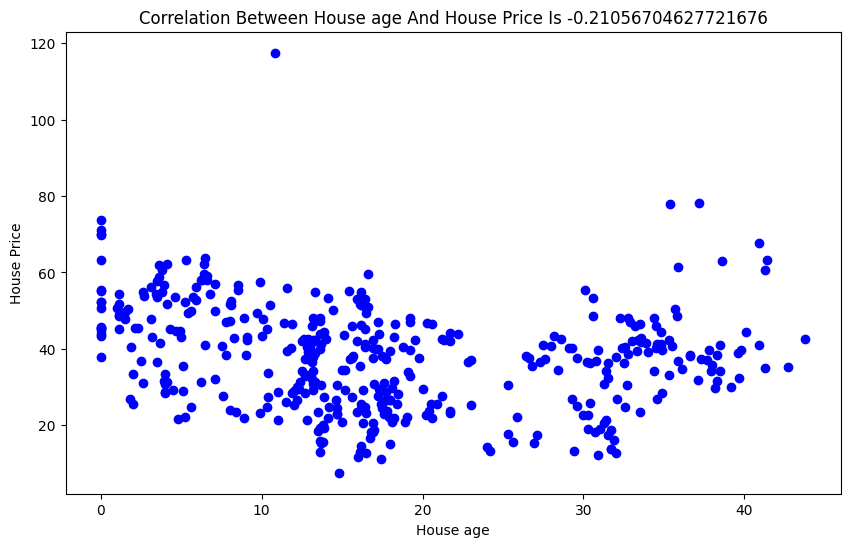

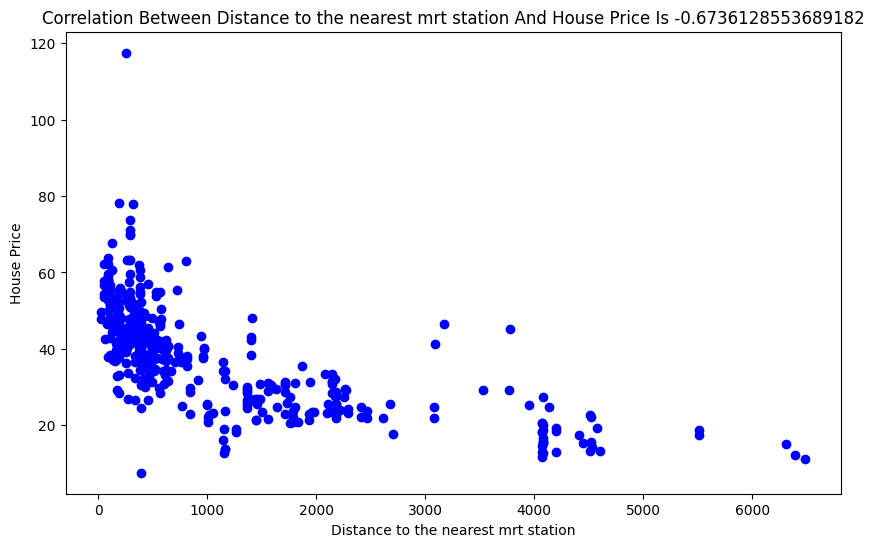

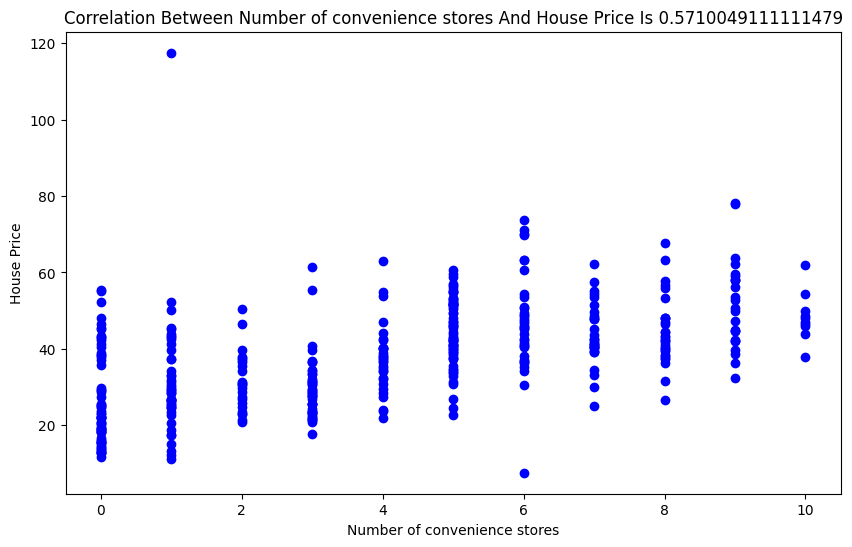

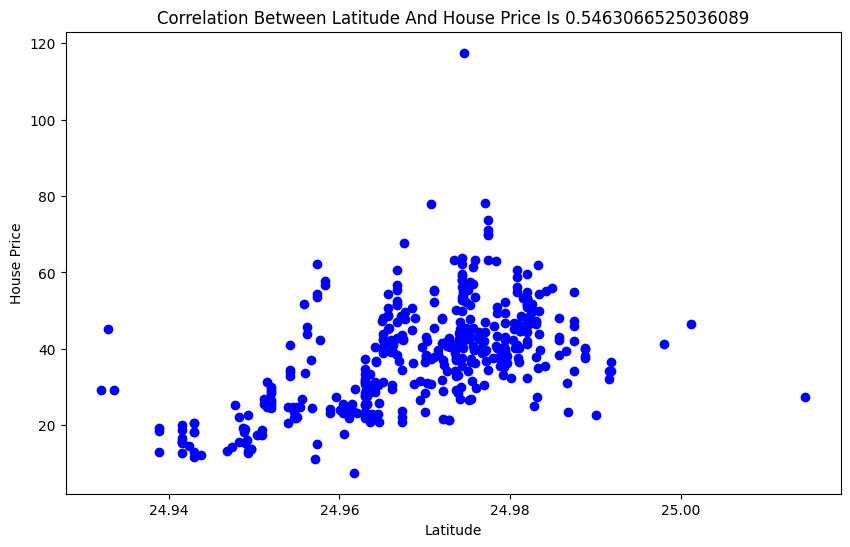

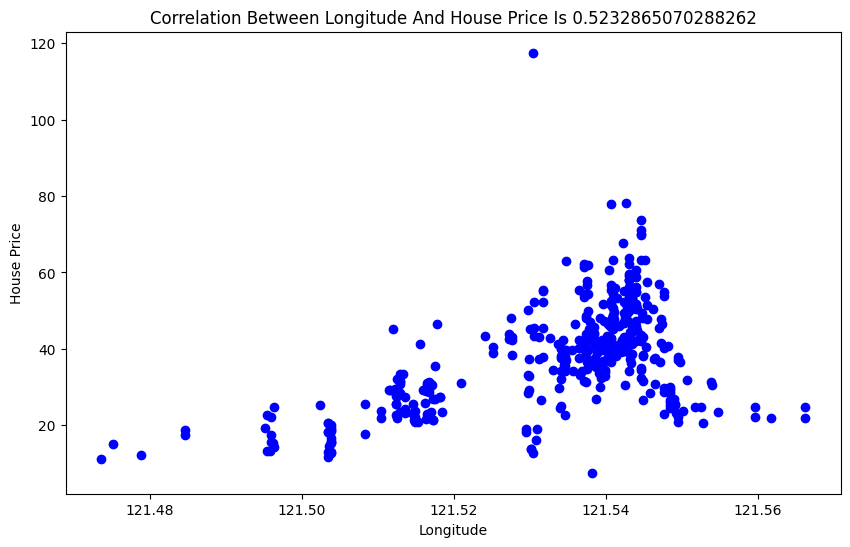

In [125]:
y_col_label = "Y house price of unit area"

correlations = df.corr()[y_col_label]
correlations = correlations.drop(y_col_label)

Y = df[y_col_label]
X= df.drop(y_col_label,axis=1)

for index,col in enumerate(X):
  plot_feature(X[col],Y,col,index,correlations[index])

### Data cleaning


In [126]:
Q1 = Y.quantile(0.25)
Q3 = Y.quantile(0.75)
IQR = Q3 - Q1

outliers_mask = (Y < (Q1 - 1.5 * IQR)) | (Y > (Q3 + 1.5 * IQR))
Y_cleaned = Y[~outliers_mask]

correlation_threshold = 0.2
selected_features = correlations[np.abs(correlations) > correlation_threshold].index

X_cleaned = X[selected_features][~outliers_mask]

### Visualize cleaned data

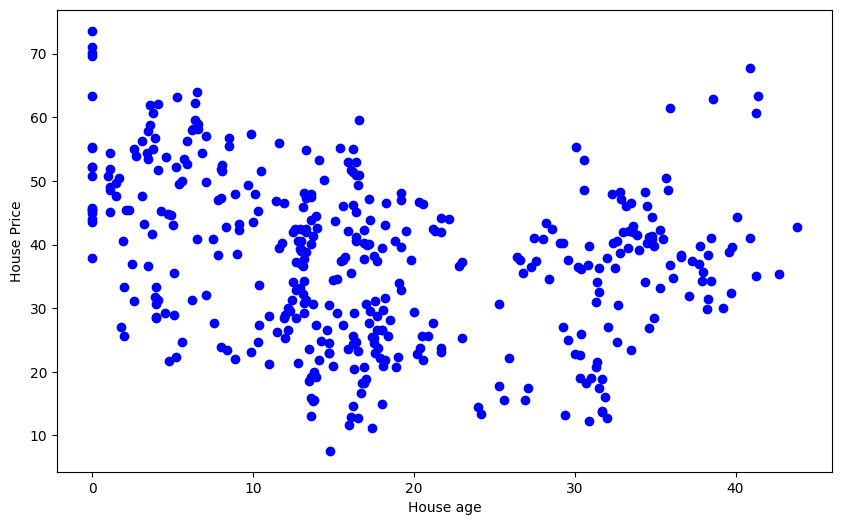

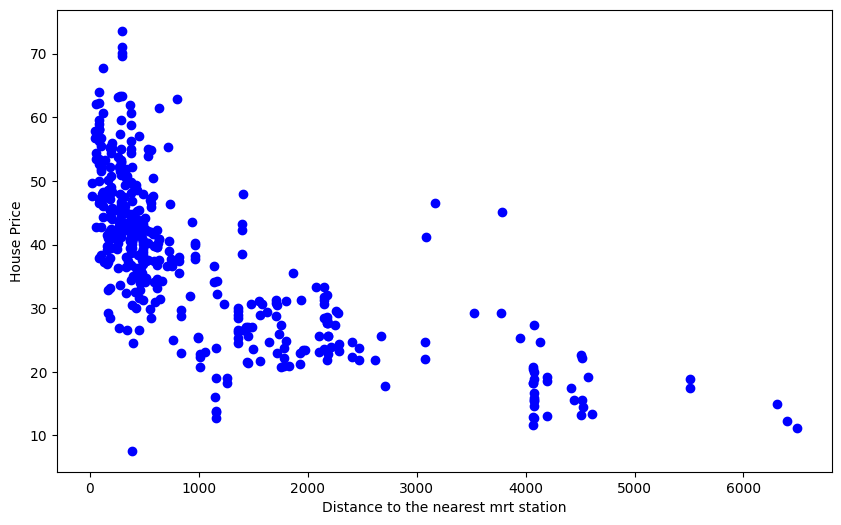

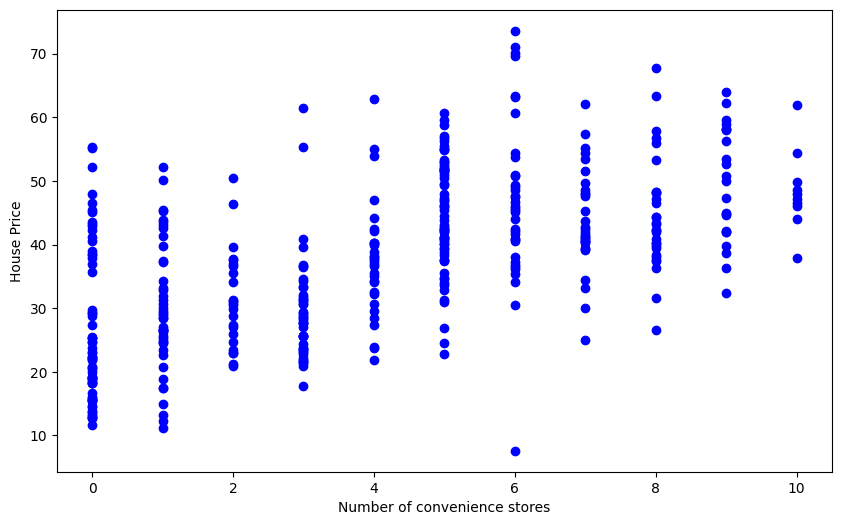

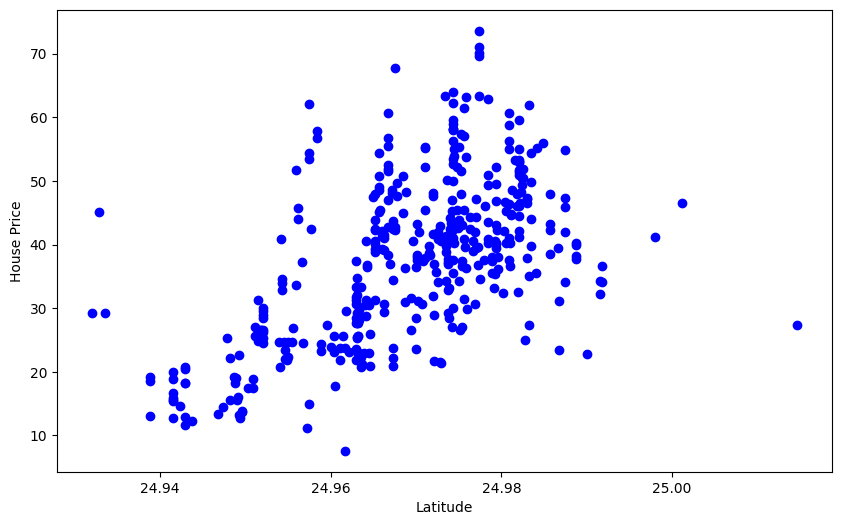

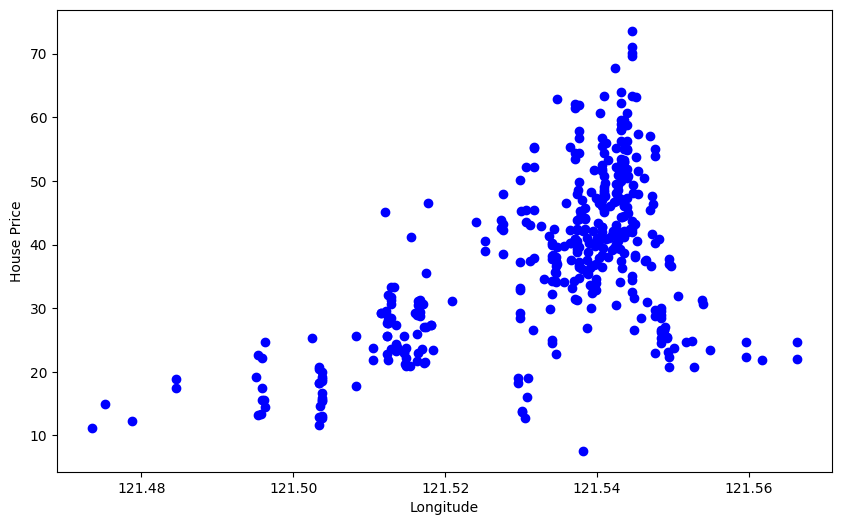

In [127]:
for (index,col) in enumerate(X_cleaned):
  plot_feature(X_cleaned[col],Y_cleaned,col,index)

In [128]:
def split_data(x: pd.DataFrame,y:pd.DataFrame):
  return train_test_split(
            X_cleaned, Y_cleaned, test_size=0.25,random_state=101
        )

## Test different degrees and calculate error

In [129]:
def test_degrees(degrees: range):
    mae_train_list = []
    mae_validation_list = []

    mse_train_list = []
    mse_validation_list = []

    score_train_list = []
    score_validation_list = []

    lowest_mean_error = float("inf")

    for degree in degrees:

        x_train, x_validation, y_train, y_validation = split_data(X_cleaned, Y_cleaned)
        # because include_bias with degree = 0 throw error
        poly = PolynomialFeatures(degree=degree, include_bias=degree == 0)

        x_train_poly = poly.fit_transform(x_train)
        x_validation_poly = poly.transform(x_validation)

        model = LinearRegression()
        model.fit(x_train_poly, y_train)

        y_train_pred = model.predict(x_train_poly)
        y_validation_pred = model.predict(x_validation_poly)

        mae_train = metrics.mean_absolute_error(y_train, y_train_pred)
        mae_validation = metrics.mean_absolute_error(y_validation, y_validation_pred)

        mse_train = metrics.mean_squared_error(y_train, y_train_pred)
        mse_validation = metrics.mean_squared_error(y_validation, y_validation_pred)

        score_train = metrics.r2_score(y_train_pred, y_train)
        score_validation = metrics.r2_score(y_validation_pred, y_validation)

        mae_train_list.append(mae_train)
        mae_validation_list.append(mae_validation)

        mse_train_list.append(mse_train)
        mse_validation_list.append(mse_validation)

        score_train_list.append(score_train)
        score_validation_list.append(score_validation)

    return mae_train_list, mae_validation_list, mse_train_list,mse_validation_list,score_train_list,score_validation_list

In [130]:
degrees = range(1,9)
mae_train_list, mae_validation_list, mse_train_list,mse_validation_list,score_train_list,score_validation_list = test_degrees(degrees)

rmse_train_list = [np.sqrt(x) for x in mse_train_list]
rmse_validation_list = [np.sqrt(x) for x in mse_validation_list]

error_data = pd.DataFrame.from_dict({
    "MSE train": mse_train_list,
    "MSE validation": mse_validation_list,

    "RMSE train": rmse_train_list,
    "RMSE validation": rmse_validation_list,

    "MAE train": mae_train_list,
    "MAE validation": mae_validation_list,

    "R2 score train": score_train_list,
    "R2 score validation": score_validation_list,
})

error_data.head(error_data.shape[0])

,MSE train,MSE validation,RMSE train,RMSE validation,MAE train,MAE validation,R2 score train,R2 score validation
0,60.793117,56.930490,7.796994,7.545230,5.854730,5.742212,0.424435,0.565306
1,40.012912,38.514011,6.325576,6.205966,4.682289,4.842709,0.683451,0.727392
2,33.659659,43.852135,5.801694,6.622094,4.246965,5.067470,0.746465,0.695363
3,28.809470,47.119174,5.367445,6.864341,3.890786,5.248622,0.790632,0.693764
4,27.114962,150.473271,5.207203,12.266755,3.865499,7.196605,0.805288,0.483357
5,35.273763,458.072837,5.939172,21.402636,4.346527,8.121357,0.730973,-0.016662
6,40.080372,2626.121649,6.330906,51.245699,4.484229,13.001263,0.682693,0.121541
7,54.456090,25534.231123,7.379437,159.794340,5.158432,24.800131,0.513617,-0.033745


## Visualize different errors

In [131]:
def plot_error(degrees: range,points_lists: tuple[list[float],list[float]],y_label: str,title: str | None = None,labels: tuple[str, str] | None = None):
  points_list_1, points_list_2 = points_lists
  points_list_1_label, points_list_2_label = labels or [f"{y_label} Train", f"{y_label} Validation"]

  plt.figure(figsize=(10,6))
  plt.plot(degrees, points_list_1, label=points_list_1_label, color="blue")
  plt.plot(degrees, points_list_2, label=points_list_2_label, color="red")
  plt.xlabel("Polynomial Degree")
  plt.title(title)
  plt.ylabel(y_label)
  plt.legend()
  plt.show()

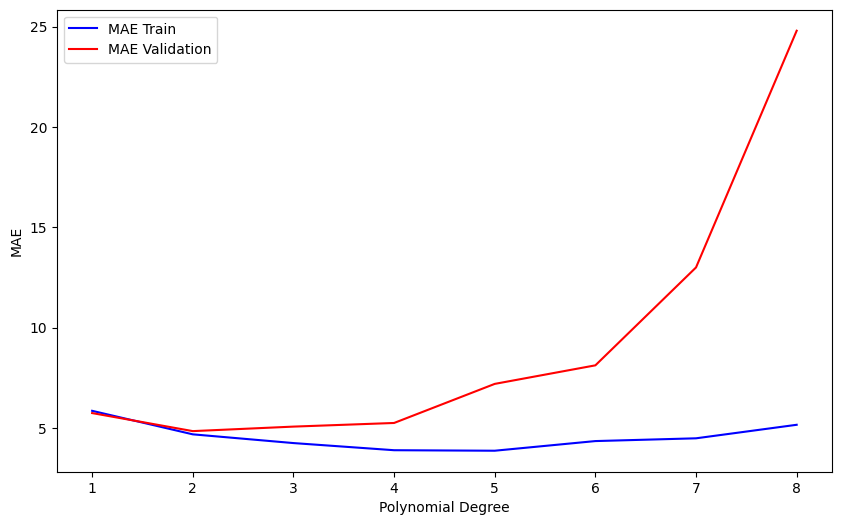

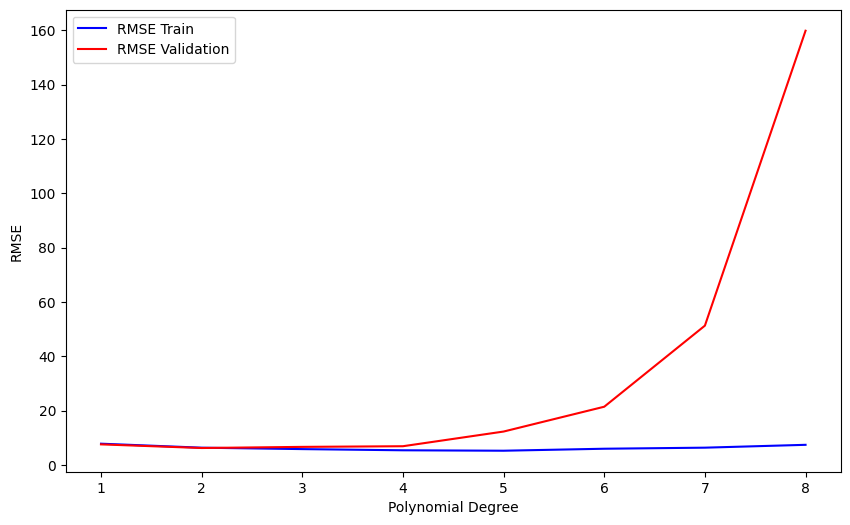

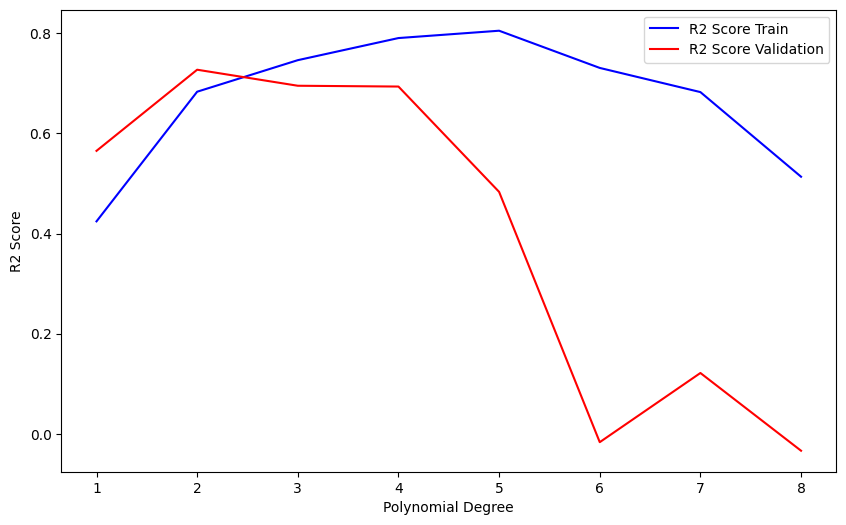

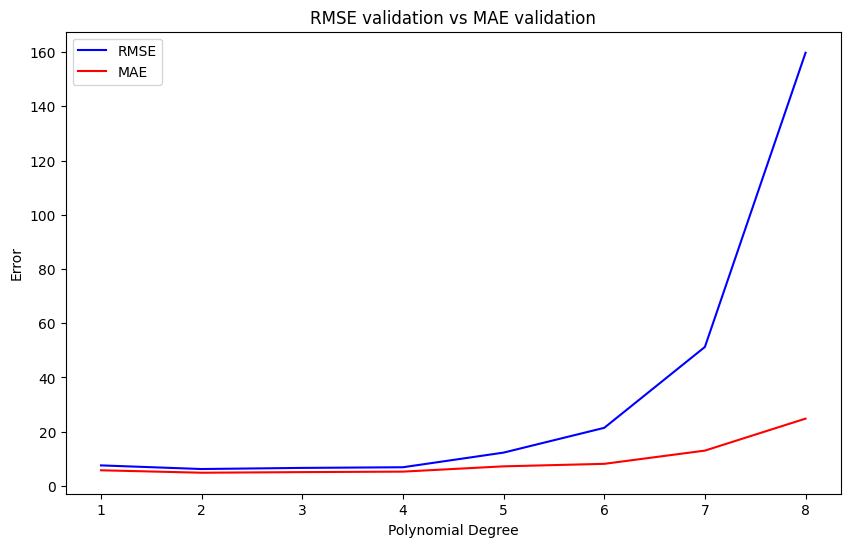

In [132]:
## MAE: Mean Absolute Error
## MSE: Mean Squared Error
## RMSE: Root Mean Squared Error
plot_error(degrees, points_lists=(mae_train_list, mae_validation_list), y_label="MAE")
plot_error(degrees, points_lists=(rmse_train_list, rmse_validation_list), y_label="RMSE")
plot_error(degrees, points_lists=(score_train_list, score_validation_list), y_label="R2 Score")
plot_error(degrees, points_lists=(rmse_validation_list, mae_validation_list), y_label="Error", labels=("RMSE", "MAE"), title="RMSE validation vs MAE validation")

In [133]:
def generate_test_data(samples: int = X_cleaned.shape[0]):
  test_data = pd.DataFrame()

  for col in X_cleaned.columns:
      mean_val = X_cleaned[col].mean()
      std_val = X_cleaned[col].std()
      test_data[col] = np.random.normal(mean_val, std_val, samples)

  return test_data


## Train data with best degree and test it

In [134]:
def plot_prediction_test(train: tuple[pd.Series,pd.Series],test: tuple[pd.Series,pd.Series], col: str,index: int):
    feature_train_data, y_train = train
    feature_test_data, y_pred_test = test

    feature_label = get_feature_label(col)

    plt.figure(figsize=(10,6))
    plt.scatter(feature_train_data, y_train, color="blue", label="Train Data")
    plt.scatter(feature_test_data, y_pred_test, color="green", label="Predicted")
    plt.xlabel(feature_label)
    plt.ylabel("House Price")
    plt.legend()
    plt.title(f"{feature_label} vs House Price")
    plt.show()

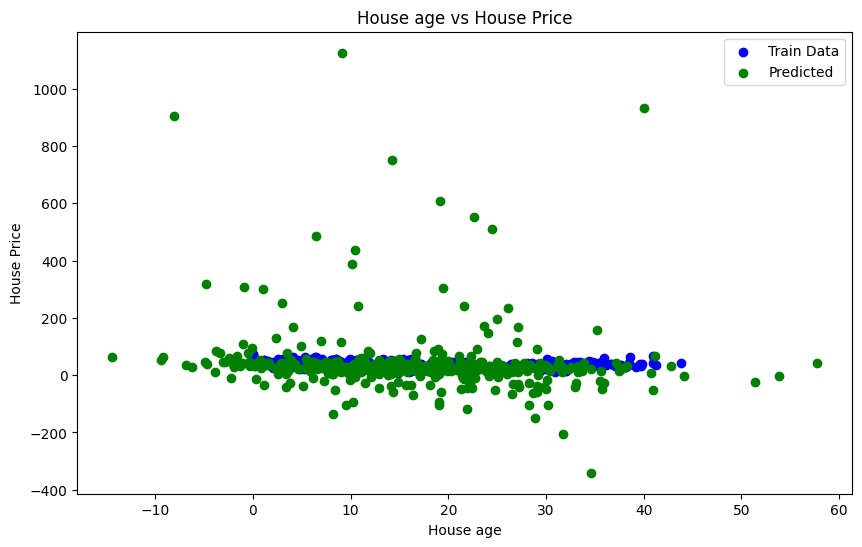

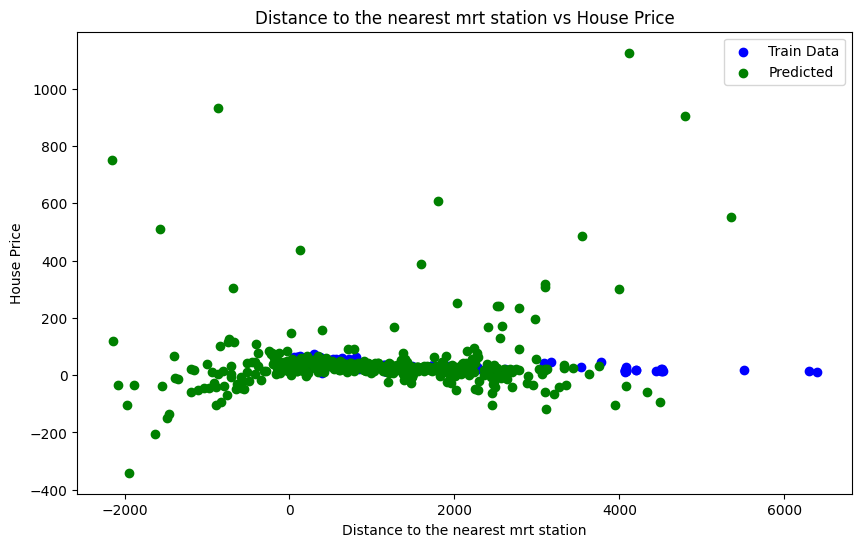

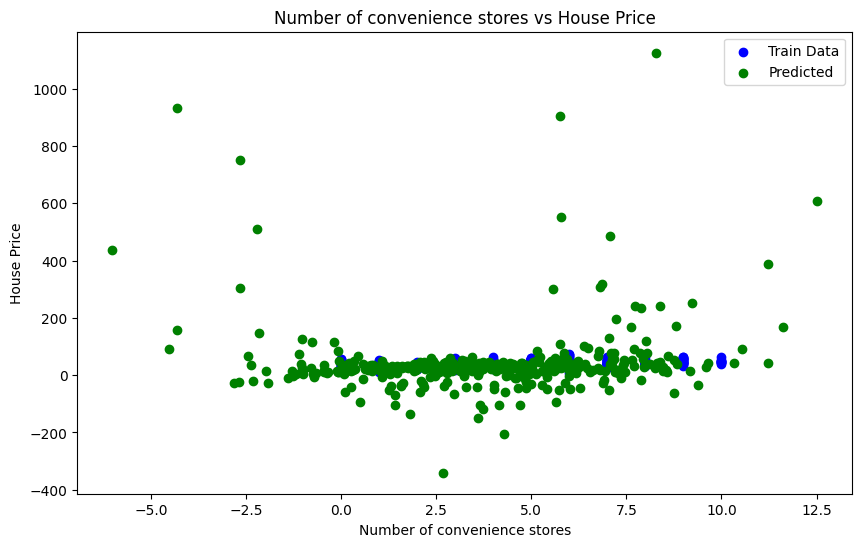

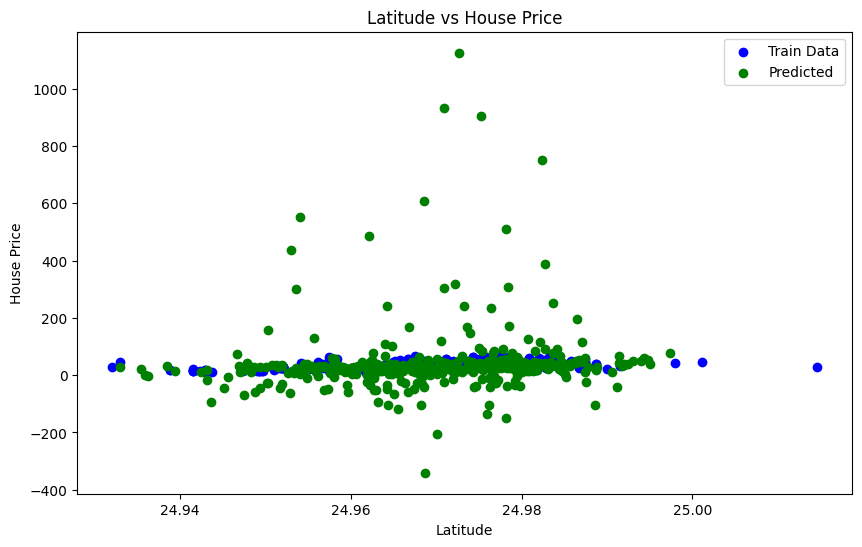

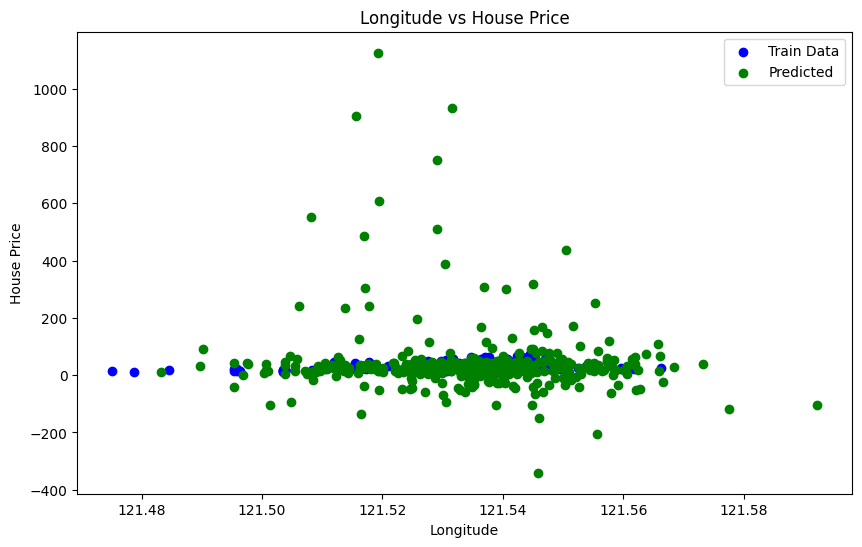

In [135]:
best_degree = 4
poly = PolynomialFeatures(degree=best_degree, include_bias=False)

x_train, _ , y_train, _ = split_data(X_cleaned, Y_cleaned)
x_train_poly = poly.fit_transform(x_train)

model = LinearRegression()
model.fit(x_train_poly, y_train)

x_test = generate_test_data()
x_test_poly = poly.transform(x_test)

y_pred_test = model.predict(x_test_poly)

for index, col in enumerate(x_test):
  train = x_train[col], y_train
  test = x_test[col], y_pred_test
  plot_prediction_test(train, test, col,index)

## Visualize importance of each feature

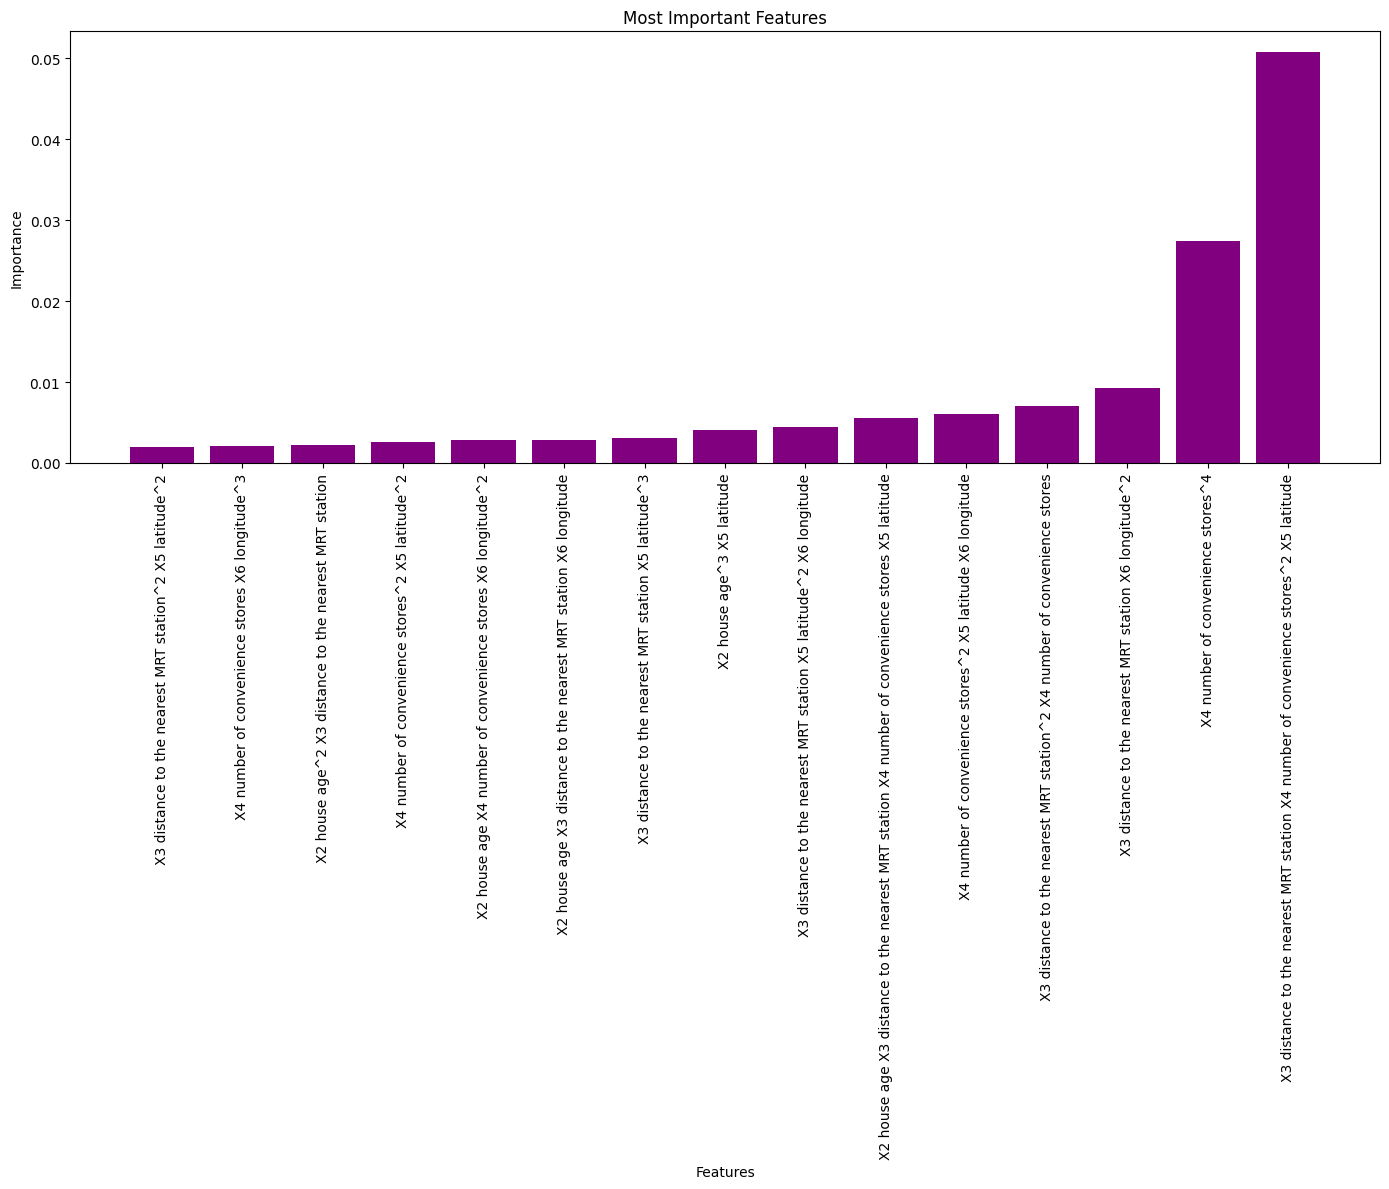

In [143]:
feature_names = poly.get_feature_names_out(X_cleaned.columns)

coefficients = model.coef_
intercept = model.intercept_
most_important_indices = np.argsort(coefficients)[-15:]

plt.figure(figsize=(14, 12))
plt.bar(feature_names[most_important_indices], coefficients[most_important_indices], color="purple")
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Most Important Features")
plt.tight_layout()
plt.show()

## Visualize predicted polynomial function

In [137]:
def get_feature_name_without_label(feature_name: str):
  # X6 longitude -> X6
  return re.sub(r"^(X\d+).*", r"\1", feature_name)

In [139]:
feature_names_without_labels = [get_feature_name_without_label(feature_name) for feature_name in feature_names]

f_x = "".join([f"{coef:.3f} * {feature}" + ("\n" if index % 8 == 0 and index != 0 else " ") for index, (coef, feature) in enumerate(zip(coefficients, feature_names_without_labels))]) + f" + {intercept:.4f}"
polynomial_function = "f(x) = \n" + f_x

# Some of the coefficients may be zero, but this is due to rounding
print(polynomial_function)

f(x) = 
-0.000 * X2 0.000 * X3 0.000 * X4 -0.000 * X5 0.000 * X6 -0.000 * X2 0.000 * X2 0.000 * X2 -0.000 * X2
-0.000 * X2 -0.000 * X3 0.000 * X3 0.000 * X3 0.000 * X3 0.000 * X4 0.000 * X4 0.000 * X4
0.000 * X5 0.000 * X5 -0.000 * X6 -0.000 * X2 0.002 * X2 0.000 * X2 -0.000 * X2 -0.000 * X2
0.000 * X2 0.001 * X2 0.001 * X2 0.003 * X2 0.000 * X2 -0.000 * X2 0.000 * X2 -0.000 * X2
-0.000 * X2 -0.000 * X2 0.000 * X3 0.007 * X3 0.001 * X3 -0.001 * X3 0.000 * X3 0.000 * X3
0.000 * X3 0.000 * X3 0.002 * X3 0.009 * X3 -0.000 * X4 0.000 * X4 0.000 * X4 -0.000 * X4
-0.000 * X4 0.000 * X4 0.000 * X5 0.000 * X5 0.000 * X5 -0.000 * X6 0.000 * X2 -0.000 * X2
0.000 * X2 0.004 * X2 -0.001 * X2 -0.000 * X2 -0.000 * X2 0.001 * X2 -0.000 * X2 0.000 * X2
-0.004 * X2 0.001 * X2 -0.002 * X2 -0.004 * X2 0.001 * X2 0.000 * X2 -0.000 * X2 0.000 * X2
-0.000 * X2 -0.000 * X2 0.006 * X2 -0.001 * X2 -0.000 * X2 -0.000 * X2 0.000 * X2 -0.002 * X2
-0.000 * X2 0.001 * X2 -0.005 * X2 -0.013 * X2 0.003 * X2 0.000 * X